In [22]:
!pip install keras

In [23]:
!pip install tensorflow

  Obtaining dependency information for keras<2.16,>=2.15.0 from https://files.pythonhosted.org/packages/fc/a7/0d4490de967a67f68a538cc9cdb259bff971c4b5787f7765dc7c8f118f71/keras-2.15.0-py3-none-any.whl.metadata
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [3]:
import pandas as pd # csv파일 로드용
import numpy as np # 행렬 연산용
import matplotlib.pyplot as plt # 데이터 시각화

#딥러닝 모델 작성 keras
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime

# Load Dataset

In [4]:
data = pd.read_csv('samsung.csv') #데이터 로드
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-14,40450,40700,39850,40050,35257.99219,11984996
1,2019-01-15,40050,41100,39850,41100,36182.36328,11492756
2,2019-01-16,41150,41450,40700,41450,36490.48438,8491595
3,2019-01-17,41700,42100,41450,41950,36930.64844,11736903
4,2019-01-18,42000,42400,41950,42300,37238.77734,11029256


# Compute Mid Price

In [5]:
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2 # 중간 가격 계산

# Create Windows

## LSTM의 기본 개념
- 최근 (50일간) 데이터를 보고 내일 데이터를 예측한다
- 50이 window 크기임 (키워도 됨)

- for문을 돌면서, result list에 한개씩 값을 추가
- 리스트 슬라이싱 기능을 사용하여 mid_prices라는 리스트에서 특정 범위의 요소들을 추출하고, 그 결과를 result라는 리스트에 추가

In [6]:
seq_len = 50
sequence_length = seq_len + 1 # 50개의 데이터 + 예측할 데이터 1개 (윈도우 하나에 51개의 데이터 저장)

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

# Normalize Data (데이터 정규)

# Normalize Data (데이터 정규)

한 윈도우에서 첫번째 값을 기준(0)으로 잡고
나머지 값들의 비율을 계산함 (각 값에 첫번째 값을 나누고, 1을 빼줌) -> 정규화 과정

그 정규화된 결과값을 다시 result에 넣어줌
  

이후 전체 데이터를 train data와 test data로 나눠줌
test set은 학습할 때, 포함시켜서는 절대 안됨.
  

윈도우마다 51개의 데이터가 들어있고
50개의 데이터를 input으로 나머지 1일의 데이터를 예측할 것임

x_train에 50개를 넣고
y_train에 1개를 넣음

1063개의 training set과, 118개의 test set이 나눠짐
1063일의 데이터를 가지고, 118일의 주식 데이터를 예측.


In [7]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.8))
train = result[:row, :] # 전체 데이터의 80%를 train set으로 분리함
np.random.shuffle(train) # training set은 랜덤으로 섞어주는게 좋음.

# 윈도우마다 51개의 데이터가 들어있고
# 50개의 데이터를 input으로 나머지 1일의 데이터를 예측할 것임

x_train = train[:, :-1] # 50개
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1] # 마지막 1개

x_test = result[row:, :-1] # 50개
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1] # 마지막 1개

x_train.shape, x_test.shape

((945, 50, 1), (236, 50, 1))

# Build a Model

keras.models.Sequential() - 모델을 순차적으로 정의하는 클래스

keras.layers.LSTM() - LSTM 레이어

summary를 보면
50개가 들어가서 1개가 나오는 것을 알 수 있음.

In [8]:
    
model = Sequential() # sequential이라는 class를 사용

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1))) # input 50개 (units 50개)

model.add(LSTM(64, return_sequences=False)) # (units 64개)

model.add(Dense(1, activation='linear')) # ouput은 1개 - 다음날의 데이터 예측

model.compile(loss='mse', optimizer='rmsprop') # 손실 함수는 Mean Squared Error 사용, optimizer는 rmsprop 사용

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 39905 (155.88 KB)
Trainable params: 39905 (155.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training

model에서 fit이라는 메소드를 사용하면, 학습이 됨.

batch_size는 한번에 몇개씩 묶어서 학습시킬 것인지
epochs=20은, 20번 동안 반복학습 한다는 의미.

In [9]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=20)

Epoch 1/20

95/95 [==============================] - 8s 51ms/step - loss: 0.0026 - val_loss: 5.9936e-04
Epoch 2/20
95/95 [==============================] - 4s 40ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 3/20
95/95 [==============================] - 3s 35ms/step - loss: 0.0011 - val_loss: 7.4238e-04
Epoch 4/20
95/95 [==============================] - 4s 42ms/step - loss: 9.6664e-04 - val_loss: 4.4203e-04
Epoch 5/20
95/95 [==============================] - 4s 38ms/step - loss: 8.7264e-04 - val_loss: 9.9145e-04
Epoch 6/20
95/95 [==============================] - 4s 42ms/step - loss: 8.4009e-04 - val_loss: 4.3561e-04
Epoch 7/20
95/95 [==============================] - 2s 19ms/step - loss: 7.8405e-04 - val_loss: 3.5487e-04
Epoch 8/20
95/95 [==============================] - 2s 21ms/step - loss: 7.6859e-04 - val_loss: 3.8382e-04
Epoch 9/20
95/95 [==============================] - 3s 35ms/step - loss: 7.2934e-04 - val_loss: 3.9898e-04
Epoch 10/20
95/95 [==============================] -

# Prediction

모델이 학습이 잘 되었는지, 그래프를 그려봄

8/8 [==============================] - 1s 10ms/step


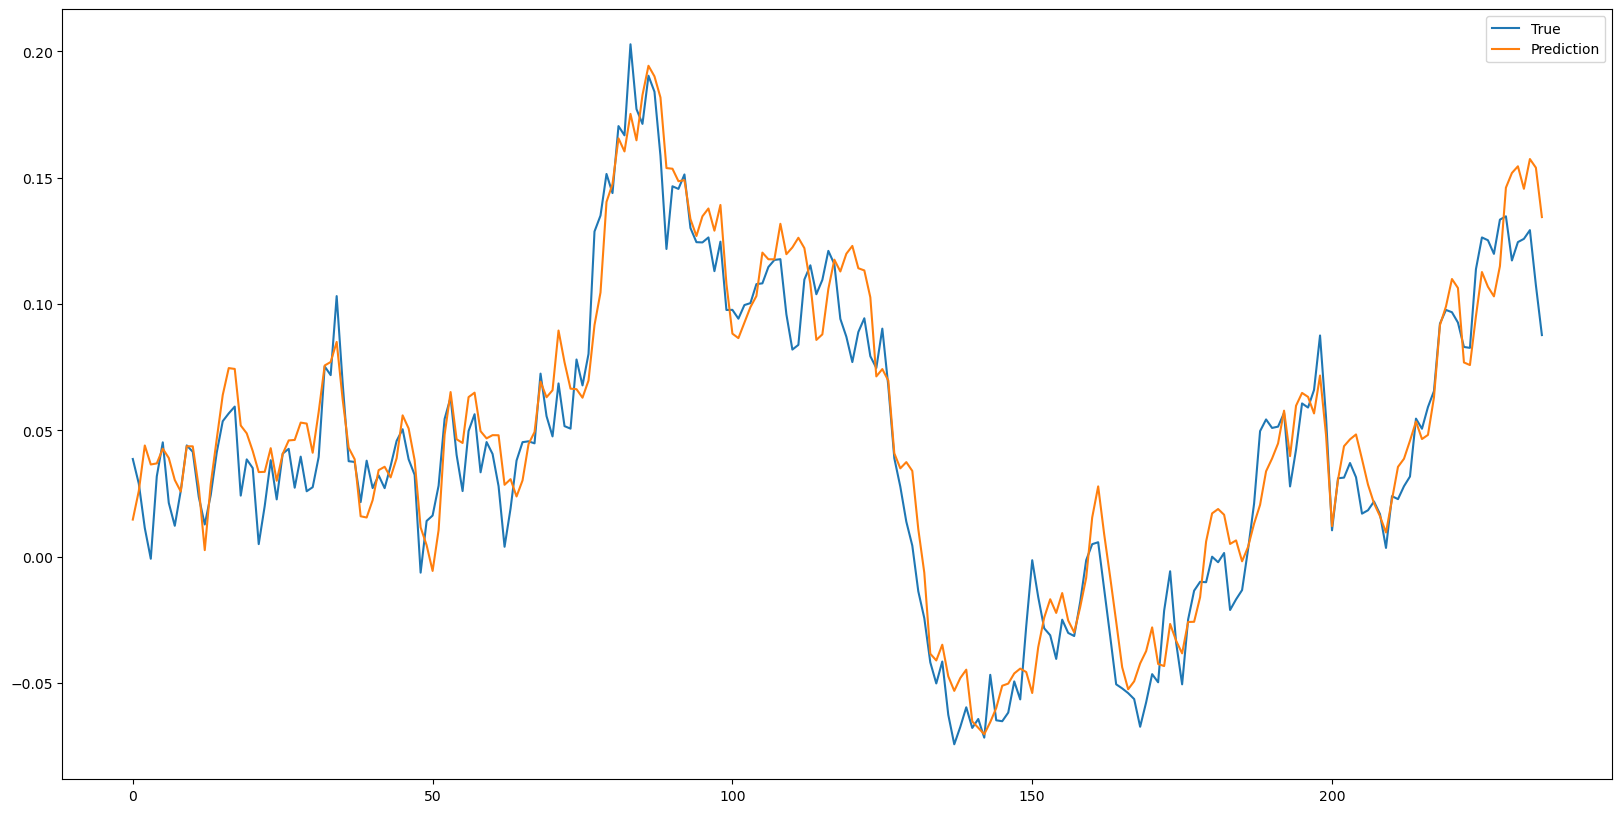

In [10]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10)) # 그래프를 생성 facecolor='white' 배경색을 흰색, figsize=(20, 10) 그래프의 크기를 설정
ax = fig.add_subplot(111) # 111은 그리드 파라미터로, 1x1 그리드의 첫 번째 서브플롯
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend() # 범례 추가
plt.show()